In [12]:
import sys
sys.path.insert(1, '/home/msantolaria/Documents/MyPythonLibrary/ClimAnag/')
import climbasis as climb
from climbasis import *
import domain as dom
import myplot
import glob
from eofs.xarray import Eof
from myplot import *
import obsinfo as obs
from obsinfo import *




In [13]:
source='/home/msantolaria/Documents/MyResearch/HMA-ClimAnalogs/Observations/'
resultsDir=source + 'Results/'
plotsDir=source + 'Plots/'

In [14]:
#resultsDir='/media/maria/MARIAEXT2/WinterTrendsObs/'
sourceData='/home/msantolaria/Documents/Data/'
sourceData1=sourceData+'noaaV2c/'
sourceData2=sourceData+'cru/'
sourceData3=sourceData+'era5/'

In [39]:
variable='tas'
units='K'
domain='global'
season='MAM'
iyr=2000
fyr=2014

In [40]:

variable='t2m'
model='era5'
info=obs.get_obs(variable,model)
fileName=info.get('filename')
ds = xr.open_dataset(sourceData+model+'/'+fileName)[variable]
units=ds.units

{'var': 't2m', 'filename': 't2m_era5_NH_mon_1979-2020.nc', 'units': 'K', 'gridlon': '-180_180', 'gridlat': '90_0'}


In [41]:

field=dom.field_dom(ds,domain)

if season[0]=='m':
    rmon=int(season.split('mon')[1])
    vals,anoms=climb.monthly_selection(field,rmon,iyr,fyr)
else:
    vals,anoms=climb.seasonal_selection(field,season,iyr,fyr)

###
##Detrended anomalies
###
anoms_detrend=climb.detrend_dim(vals, 'time', deg=1)
###
##Clim and std dev
###
clim=vals.mean('time')
if units=='K':
    clim=clim-273.15
std=vals.std('time')
std_det=anoms_detrend.std('time')

par=climb.trend_vect(anoms.time,anoms,'time')
trend=par[0]
intercept=par[1]
rvalue=par[2]
pvalue=par[3]
stderr=par[4]


trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4


In [43]:
confidence=0.975
df=anoms.shape[0]-1
t=stats.t.ppf(confidence,df)
rs=math.sqrt((t*t)/(t*t + df))

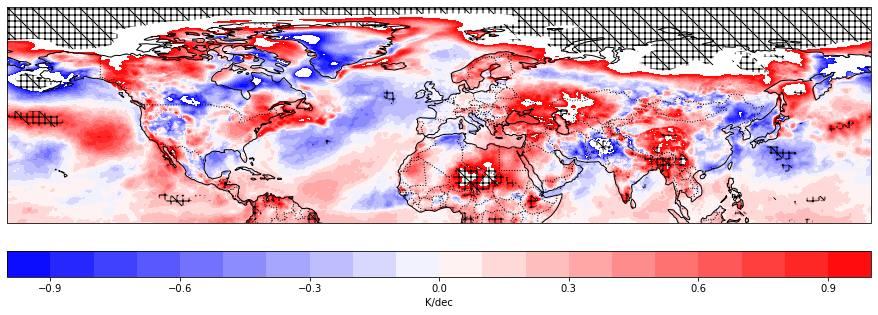

In [45]:
clevsT=np.arange(-1,1.1,0.1)
cmapT='bwr'
###
##Spatial trend
###
fig,axs= plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(20,18))

lat,lon=climb.latlon(par[0])
lons, lats = np.meshgrid(par[0][lon] ,par[0][lat])
CS1=axs.contourf(lons,lats, 10*par[0][:,:],clevsT,
                transform=ccrs.PlateCarree(),
                cmap=cmapT,extent='both')
levels=[0,0.05,1.0]
cs = axs.contourf(lons,lats,par[3][:,:], transform=ccrs.PlateCarree(),levels=levels,
                hatches=["++", ""], alpha=0.)

levels=[0,rs,1.0]
cs = axs.contourf(lons,lats,abs(par[2][:,:]), transform=ccrs.PlateCarree(),levels=levels,
                hatches=["", "\\"], alpha=0.)

# Draw the coastines for each subplot
axs.coastlines()
axs.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
#axs.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='None', facecolor='None'))
   # Longitude and latitude labels
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.35, top=0.8, left=0.20, right=0.80,
                wspace=0.05, hspace=0.5)
# Add a colorbar axis at the bottom of the graph
#([xmin,ymin,dx,dy])
cbar_ax = fig.add_axes([0.2, 0.45, 0.6, 0.02])
# Draw the colorbar
cbar=fig.colorbar(CS1, cax=cbar_ax,orientation='horizontal',label='%s/dec'%(units))
## Add a big title at the top
#ofileT='spatialtrend_'+variable+'_'+model+'_'+exp+'_'+domain+'_'+season+'_'+str(iyr)+'_'+str(fyr)
#plt.suptitle(ofileT,y=0.68)
#fig.savefig(plotsDir+ofileT+'.png',format='png')
#print('Figure save at ',plotsDir, 'as',ofileT)
plt.show()